In [13]:
import pandas as pd
import numpy as np

import seaborn as sns
import pylab as plt

from pymer4.models import Lmer
from sklearn import preprocessing,metrics,model_selection
from scipy import stats
import statsmodels.api as sm

In [1]:
def plot_context():
    sns.set_context("talk", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":16,"font_scale":0.9})

In [2]:
kind = 'OnOff'

In [4]:
# load data ppmi
ppmi = pd.read_csv(f'/scratch/c.c21013066/data/ppmi/phenotypes/phenotypes/clinical_progression_raw_{kind}_withSWEDD.csv',index_col=0)
ppmi = ppmi.rename(columns={'gender':'sex_male','updrs_iii':'UPDRS_III','updrs_i':'UPDRS_I','updrs_ii':'UPDRS_II'})

In [5]:
# get data OPDC discovery
opdc = pd.read_csv(f'/scratch/c.c21013066/data/opdc/clinical_progression_raw_{kind}.csv',index_col=0)
opdc['ON'] = 1 - opdc['untreated']
opdc = opdc.rename(columns={'disease_duration':'time_since_diagnosis','age':'visit_age','Visit':'visit'})
opdc = opdc[opdc['ON'].isin([0,1])]

In [6]:
# get data OPDC tracking
track = pd.read_csv(f'/scratch/c.c21013066/data/opdc/tracking/clinical_progression_raw_{kind}.csv',index_col=0)
track = track.rename(columns={'disease_duration':'time_since_diagnosis','age':'visit_age','Visit':'visit'})
track = track[track['ON'].isin([0,1])]

In [7]:
data = [ppmi,opdc,track]
targets_norm = ['UPDRS_III','UPDRS_I','UPDRS_II']
cohorts = ['PPMI','Discovery','Tracking']

In [8]:
# fit model
# create linear mixed effect model
# fixed: diagnosis age, sex male
# random: intercept,time by participant
family = 'poisson' # or poisson (gamma and inverse_gaussian not numerically stable, binomial does not fit data type)
transform='' # none or boxcox
results_all = []
metas_all = []
models_all = []
for data_un,cohort in zip(data,cohorts):
    # prepare dataframe for extracted random intercept and slope
    data_rate_slope = data_un.groupby('participant').first()[np.hstack(['sex_male','time_since_diagnosis','visit_age',
                                                                        'diagnosis_age','ON'])]
    models = []
    metas = []
    results = []
    for target in targets_norm:
        
        meta = pd.DataFrame(columns=['participants','visit'],index=targets_norm)
        
        # only use visits where clinical data available
        data_tar = data_un.dropna(subset=[target],how='any',axis='rows')
        
        if transform=='boxcox':
            print('boxcox transform')
            data_tar[target] = data_tar[target]+1
            data_tar[target], _ = stats.boxcox(data_tar[target])
            
        # need at least 2 visits to get slope  
        n_visits = data_tar.groupby('participant').size().rename('n_visits')
        data_tar = pd.merge(data_tar,n_visits,on='participant',suffixes=['_drop',''])
        data_tar = data_tar.drop(columns=['n_visits_drop'])
        data_tar = data_tar[data_tar['n_visits']>=2]
        
        data_tar = data_tar.sort_values(['participant','time_since_diagnosis'])
        
        # transform data
        data_tar[np.hstack([['diagnosis_age']])] = preprocessing.StandardScaler().fit_transform(data_tar[np.hstack([[
                                                                                                        'diagnosis_age']])])
        if family == 'poisson':
            # requires integer
            data_tar[target] = data_tar[target].round()
        elif family == 'gaussian':
            data_tar[[target]] = preprocessing.StandardScaler().fit_transform(data_tar[[target]])
        
        # fit model
        md = Lmer(f"{target} ~ time_since_diagnosis + sex_male + diagnosis_age + ON + (time_since_diagnosis|participant)", 
                  data = data_tar[[f'{target}','sex_male','diagnosis_age','participant','ON','time_since_diagnosis']],family=family)        
        md.fit()
        models.append(md)
        
        # extract slope and intercept for each individual
        data_intercept_tar = pd.DataFrame(md.ranef['(Intercept)'].values,columns=[f'{target}_intercept'],
                                          index=np.unique(data_tar.participant))
        data_rate_tar = pd.DataFrame(md.ranef['time_since_diagnosis'].values,columns=[f'{target}_slope'],
                                     index=np.unique(data_tar.participant))
        data_rate_slope = data_rate_slope.merge(data_intercept_tar,right_index=True,left_index=True,how='outer')
        data_rate_slope = data_rate_slope.merge(data_rate_tar,right_index=True,left_index=True,how='outer')  
        meta.loc[target] = [len(np.unique(data_tar.participant)),data_tar.shape[0]]
        results.append(data_rate_slope)
        metas.append(meta)
        
    models_all.append(models)
    metas_all.append(metas)
    results_all.append(results)

Formula: UPDRS_III~time_since_diagnosis+sex_male+diagnosis_age+ON+(time_since_diagnosis|participant)

Family: poisson	 Inference: parametric

Number of observations: 5093	 Groups: {'participant': 472.0}

Log-likelihood: -18113.449 	 AIC: 36242.898

Random effects:

                             Name    Var    Std
participant           (Intercept)  0.282  0.531
participant  time_since_diagnosis  0.005  0.072

                     IV1                   IV2   Corr
participant  (Intercept)  time_since_diagnosis -0.494

Fixed effects:

Formula: UPDRS_I~time_since_diagnosis+sex_male+diagnosis_age+ON+(time_since_diagnosis|participant)

Family: poisson	 Inference: parametric

Number of observations: 5235	 Groups: {'participant': 472.0}

Log-likelihood: -13272.918 	 AIC: 26561.835

Random effects:

                             Name    Var    Std
participant           (Intercept)  0.496  0.704
participant  time_since_diagnosis  0.006  0.076

                     IV1                   IV2   Corr
p

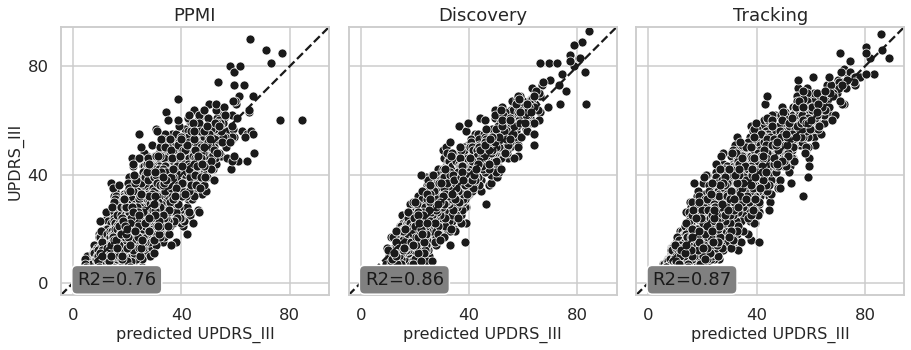

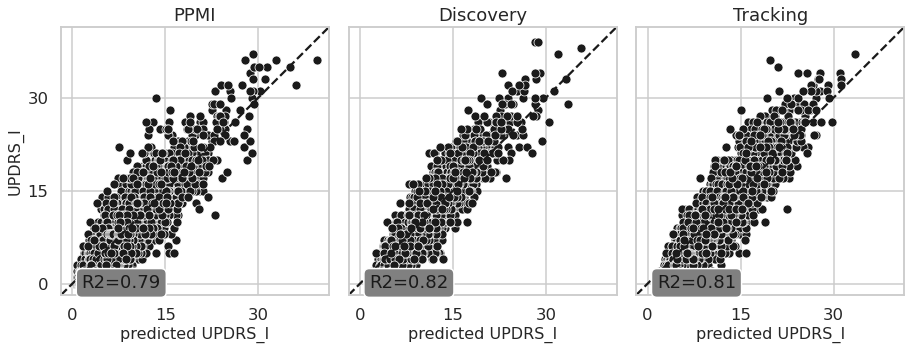

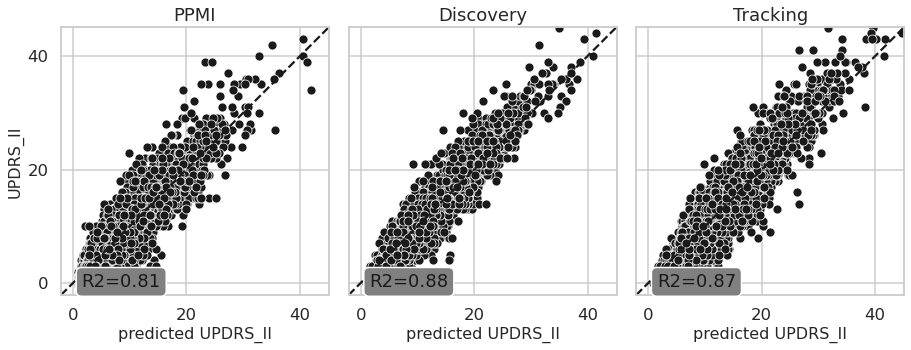

In [11]:
# evaluate fit
for t,target in enumerate(targets_norm):
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(13,6),sharex=True,sharey=True)
    plot_context()
    r2 = pd.DataFrame(columns=['no random effects','with random effects'],index=cohorts)
    for (ci,c),ax in zip(enumerate(cohorts),axes.flatten()):
        md = models_all[ci][t]
        if md.data[target].isna().sum() < md.data[target].shape[0]/2:
            sns.set()
            sns.set_style('whitegrid')
            plot_context()
            sns.scatterplot(x="fits", y=f"{target}", data=md.data,ax=ax,color='k',label='with random effects',legend=False)
            r = metrics.r2_score(md.data[target],md.data['fits'])
            pred = md.predict(md.data)
            #sns.scatterplot(x=pred, y=md.data[target],ax=ax,color='gray',label='no random effects',legend=False)
            #r_pred = metrics.r2_score(md.data[target],pred)
            r2.loc[c,'with random effects'] = r
            #r2.loc[c,'no random effects'] = r_pred
            #print(r,r_pred)
            minx = min(ax.get_xlim()[0],ax.get_ylim()[0])
            maxx = max(ax.get_xlim()[1],ax.get_ylim()[1])
            ax.set_xlim([minx,maxx])
            ax.set_ylim([minx,maxx])
            ax.plot([0,1],[0,1],transform=ax.transAxes,color='k',ls='--')
            ax.set(adjustable='box', aspect='equal')
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.set_xlabel(f'predicted {target}')
            ax.set_ylabel(target)
            ax.legend().remove()
            ax.text(1.5,-0.7,f'R2={r:.2f}',color='k',bbox=dict(boxstyle='round', facecolor='gray', alpha=1))
            #ax.text(2,-1.5,f'R2={r_pred:.2f}',color='gray')
            ax.set_title(c)
    #plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(f'/scratch/c.c21013066/images/opdc/progression/residual_{target}_cohortcomparison_R2_{family}.png',bbox_inches='tight',dpi=200)

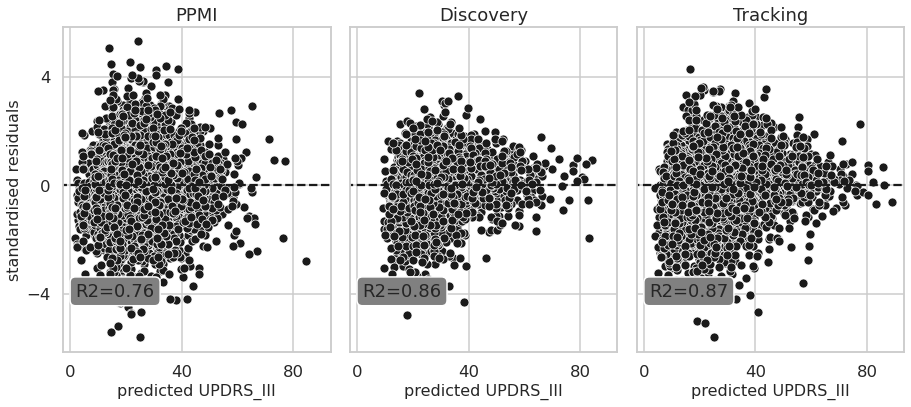

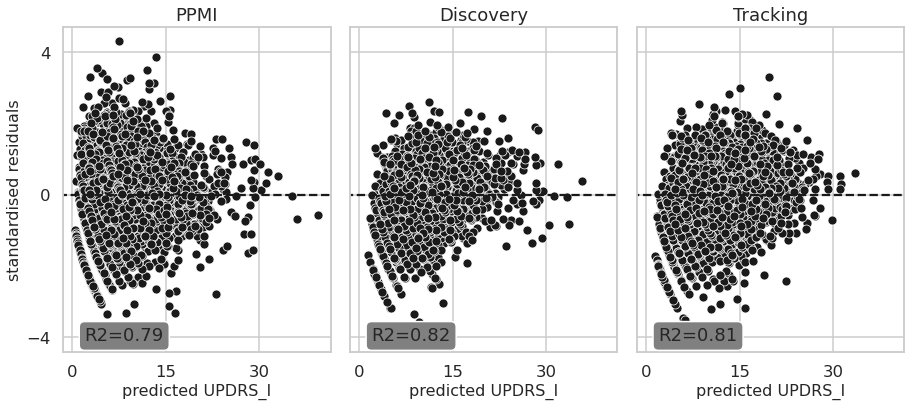

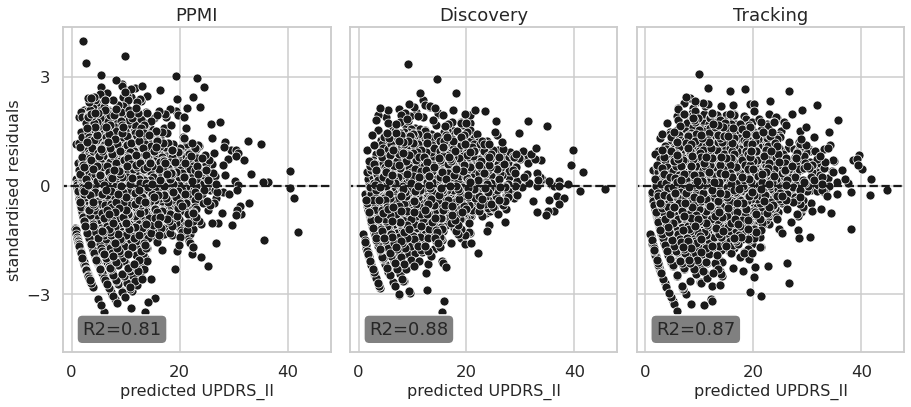

In [12]:
# check residuals
for t,target in enumerate(targets_norm):
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(13,6),sharex=True,sharey=True)
    plot_context()
    r2 = pd.DataFrame(columns=['no random effects','with random effects'],index=cohorts)
    for (ci,c),ax in zip(enumerate(cohorts),axes.flatten()):
        md = models_all[ci][t]
        if md.data[target].isna().sum() < md.data[target].shape[0]/2:
            sns.set()
            sns.set_style('whitegrid')
            plot_context()
            sns.scatterplot(x="fits", y=f"residuals", data=md.data,ax=ax,color='k',label='with random effects',legend=False)
            r = metrics.r2_score(md.data[target],md.data['fits'])
            pred = md.predict(md.data)
            #sns.scatterplot(x=pred, y=md.data[target],ax=ax,color='gray',label='no random effects',legend=False)
            r_pred = metrics.r2_score(md.data[target],pred)
            r2.loc[c,'with random effects'] = r
            r2.loc[c,'no random effects'] = r_pred
            #minx = min(ax.get_xlim()[0],ax.get_ylim()[0])
            #maxx = max(ax.get_xlim()[1],ax.get_ylim()[1])
            #ax.set_xlim([0,100])
            #ax.set_ylim([-20,20])
            #ax.plot([0,1],[0,1],transform=ax.transAxes,color='k',ls='--')
            ax.axhline(0,-3,3,color='k',ls='--')
            #ax.set(adjustable='box', aspect='equal')
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.set_xlabel(f'predicted {target}')
            ax.set_ylabel('standardised residuals')
            ax.legend().remove()
            ax.text(2,-4.1,f'R2={r:.2f}',bbox=dict(boxstyle='round', facecolor='gray', alpha=1))
            ax.set_title(c)
        #plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.savefig(f'/scratch/c.c21013066/images/opdc/progression/residual_{target}_cohortcomparison_resid_{family}.png',bbox_inches='tight')

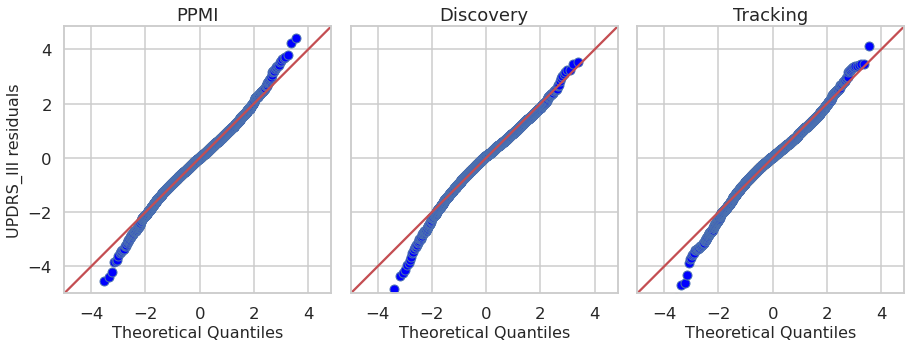

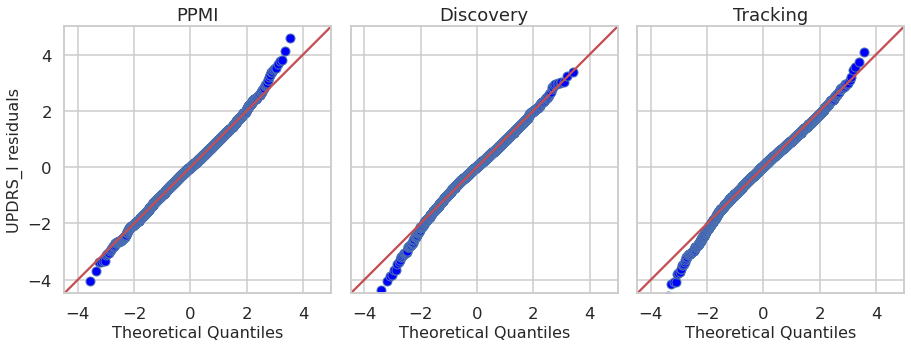

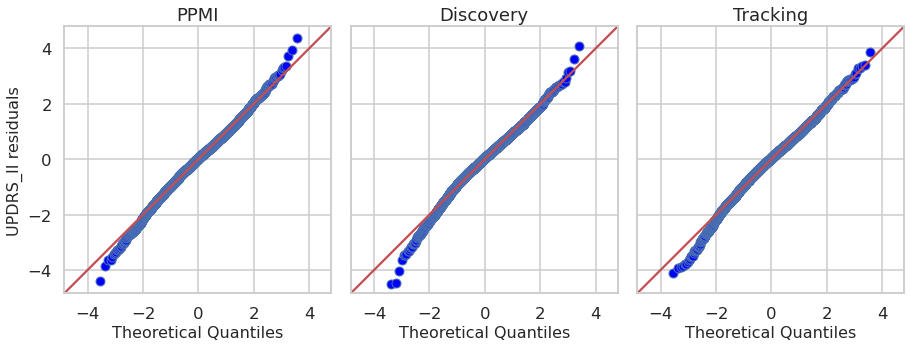

In [14]:
# qq plot
for t,target in enumerate(targets_norm):
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(13,6),sharex=True,sharey=True)
    plot_context()
    r2 = pd.DataFrame(columns=['no random effects','with random effects'],index=cohorts)
    for (ci,c),ax in zip(enumerate(cohorts),axes.flatten()):
        md = models_all[ci][t]
        if md.data[target].isna().sum() < md.data[target].shape[0]/2:
            sns.set()
            sns.set_style('whitegrid')
            plot_context()
            sm.qqplot(md.data.residuals, fit=True, line="45",ax=ax)
            ax.set(adjustable='box', aspect='equal')
            ax.set_title(c)
            if ci == 0:
                ax.set_ylabel(f'{target} residuals')
            else:
                ax.set_ylabel('')
        #plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.savefig(f'/scratch/c.c21013066/images/opdc/progression/qqplot_{target}_cohortcomparison_{family}.png',bbox_inches='tight')

In [15]:
# normality test for residuals
shapiro = pd.DataFrame(columns=['shapiro statistic','pvalue'],
                           index=pd.MultiIndex.from_product([cohorts,targets_norm],names=['cohort','target']))
for t,target in enumerate(targets_norm):
    for ci,c in enumerate(cohorts):
        md = models_all[ci][t]
        resid = md.data.residuals
        sh = stats.shapiro(resid)
        shapiro.loc[(c,target),'shapiro statistic'] = sh[0]
        shapiro.loc[(c,target),'pvalue'] = sh[1]
shapiro

/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


shapiro statistic       pvalue
cohort    target                                  
PPMI      UPDRS_III          0.992999  3.95532e-15
          UPDRS_I            0.997661  3.54182e-07
          UPDRS_II           0.996333  3.96685e-10
Discovery UPDRS_III          0.986364  8.06271e-16
          UPDRS_I            0.993593  3.12631e-10
          UPDRS_II            0.99123  1.24144e-12
Tracking  UPDRS_III          0.986962  1.60572e-21
          UPDRS_I            0.992597  1.99101e-16
          UPDRS_II           0.993749  5.67215e-15